In [1]:
import numpy as np
import sys
import os
from non_layered_neural_net import nlnn
from layered_neural_net import lnn
import matplotlib.pyplot as plt
import psutil
from memory_profiler import memory_usage
import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
f = open('lnn_run3_data/networks_lnn.pkl', 'rb') 
networks = pickle.load(f)
print("networks loaded")

networks loaded


In [3]:
lnn = True
try:
    print(len(networks[0][1].weights))
except:
    lnn = False

2


In [4]:
def load_local_mnist_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)

def one_hot_encode(x):
    out = np.zeros((len(x), max(x) + 1))
    for i in range(len(x)):
        out[i][x[i]] = 1
    return out


(train_X, train_y), (test_X, test_y) = load_local_mnist_data('mnist.npz')

y_train_ohe = one_hot_encode(train_y)
y_test_ohe = one_hot_encode(test_y)
# flatten images
x_train = train_X.reshape(len(train_X), 28 * 28)
x_test = test_X.reshape(len(test_X), 28 * 28)

x_test = np.array_split(x_test, 10)
y_test_ohe = np.array_split(y_test_ohe, 10)


In [5]:
if isinstance(networks[0], tuple):
    n = []
    for i in networks:
        n.append(i[1])
    networks = n

In [6]:
def get_perf(t):
    return t[0]

def evaluate_performance(population, x, y):
    performances = []
    print("evaluating performances", end="")
    for net in population:
        if(lnn):
            predictions = net.predict(x)[0]
        else:
            predictions = net.predict(x,6)[0]
        correct_count = len(x) - (np.sum(np.abs(y - predictions)) / 2)
        performances.append((correct_count / len(x), net))
        print("|", end="")
    print(" done!", end=" ")
    # sort by best performance
    performances.sort(key=get_perf, reverse=True)
    return performances


networks = evaluate_performance(networks, x_train[:1000], y_train_ohe[:1000])

evaluating performances|||||||||||||||||||||||||||||| done! 

In [7]:
for i in networks:
    print(i[0])

0.53
0.53
0.53
0.529
0.529
0.529
0.529
0.529
0.529
0.529
0.529
0.529
0.529
0.529
0.529
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.527
0.527
0.526
0.526
0.525


In [8]:
net = networks[0][1]
predicted_ohe, raw_outputs = 1,2
if(lnn):
    predicted_ohe, raw_outputs = net.predict(x_train)
else:
    predicted_ohe, raw_outputs = net.predict(x_train,6)


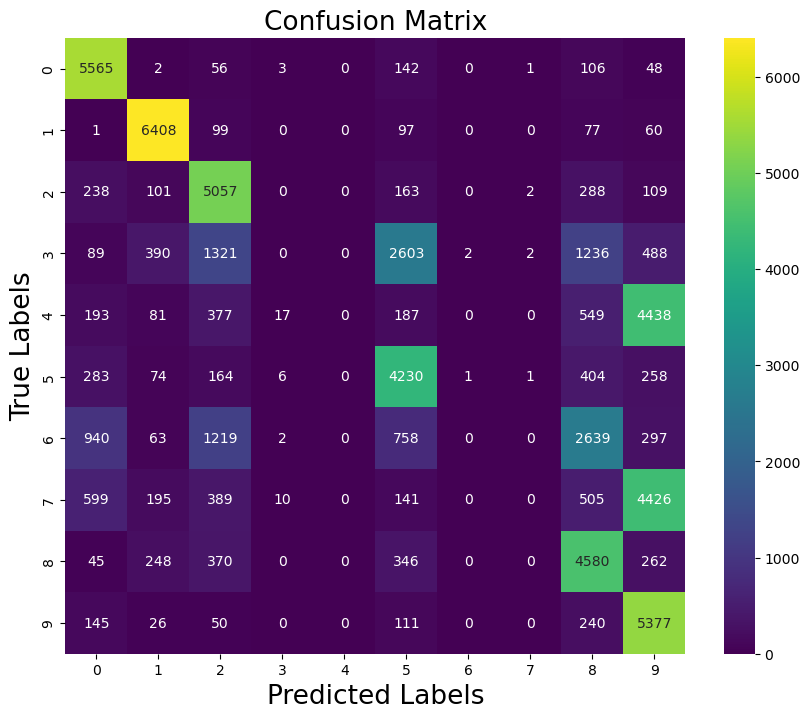

/var/folders/7z/92ygtml926q57l2kh5j69twm0000gn/T/ipykernel_82894/2758682446.py:19: RuntimeWarning: overflow encountered in exp
  softmax_outputs = np.exp(raw_outputs) / np.sum(np.exp(raw_outputs), axis=1, keepdims=True)
/var/folders/7z/92ygtml926q57l2kh5j69twm0000gn/T/ipykernel_82894/2758682446.py:19: RuntimeWarning: invalid value encountered in divide
  softmax_outputs = np.exp(raw_outputs) / np.sum(np.exp(raw_outputs), axis=1, keepdims=True)


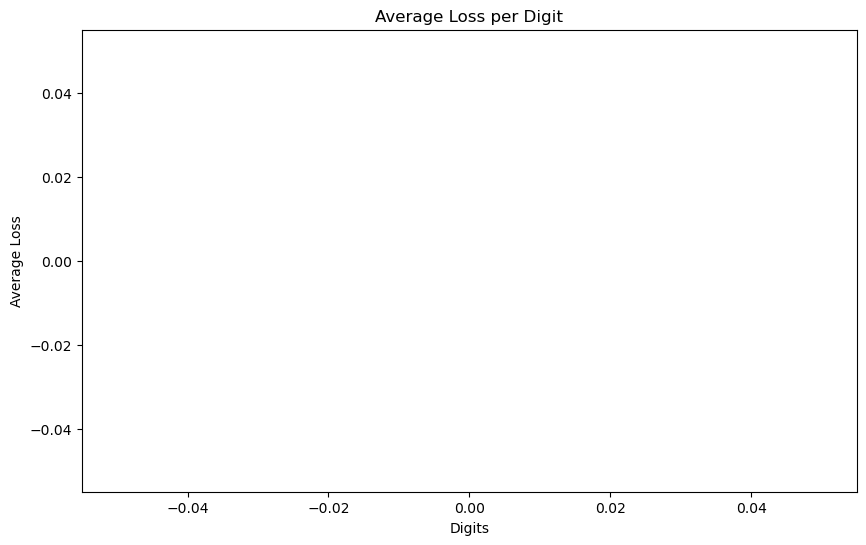

In [9]:


# Convert one-hot predictions to labels
predicted_labels = np.argmax(predicted_ohe, axis=1)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(train_y, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='g')
plt.xlabel('Predicted Labels',fontsize=19)
plt.ylabel('True Labels',fontsize=19)
plt.title('Confusion Matrix',fontsize=19)
plt.savefig("generated_pdf_plots/lnn_analysis_4/confusion_mat.pdf")
plt.show()

# Calculate cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9), axis=1)

# Softmax for raw outputs
softmax_outputs = np.exp(raw_outputs) / np.sum(np.exp(raw_outputs), axis=1, keepdims=True)

# Calculate loss per example
losses = cross_entropy_loss(y_train_ohe, softmax_outputs)

# Average loss per digit
avg_loss_per_digit = {}
for digit in range(10):
    avg_loss_per_digit[digit] = np.mean(losses[train_y == digit])

# Plot average loss per digit
plt.figure(figsize=(10, 6))
plt.bar(avg_loss_per_digit.keys(), avg_loss_per_digit.values())
plt.xlabel('Digits')
plt.ylabel('Average Loss')
plt.title('Average Loss per Digit')
plt.show()


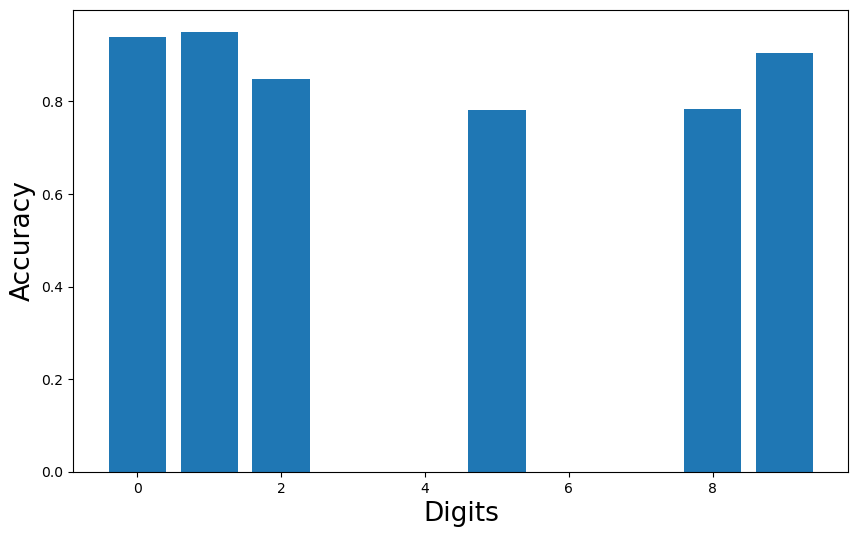

In [10]:
accuracy_per_digit = {}
for digit in range(10):
    correct_preds = np.sum((train_y == digit) & (predicted_labels == digit))
    total_preds = np.sum(train_y == digit)
    accuracy_per_digit[digit] = correct_preds / total_preds if total_preds > 0 else 0
plt.figure(figsize=(10, 6))
plt.bar(accuracy_per_digit.keys(), accuracy_per_digit.values())
plt.xlabel('Digits',fontsize=19)
plt.ylabel('Accuracy',fontsize=19)
plt.savefig("generated_pdf_plots/lnn_analysis_4/accuracy_per_digit.pdf")
plt.show()

NameError: name 'precision' is not defined

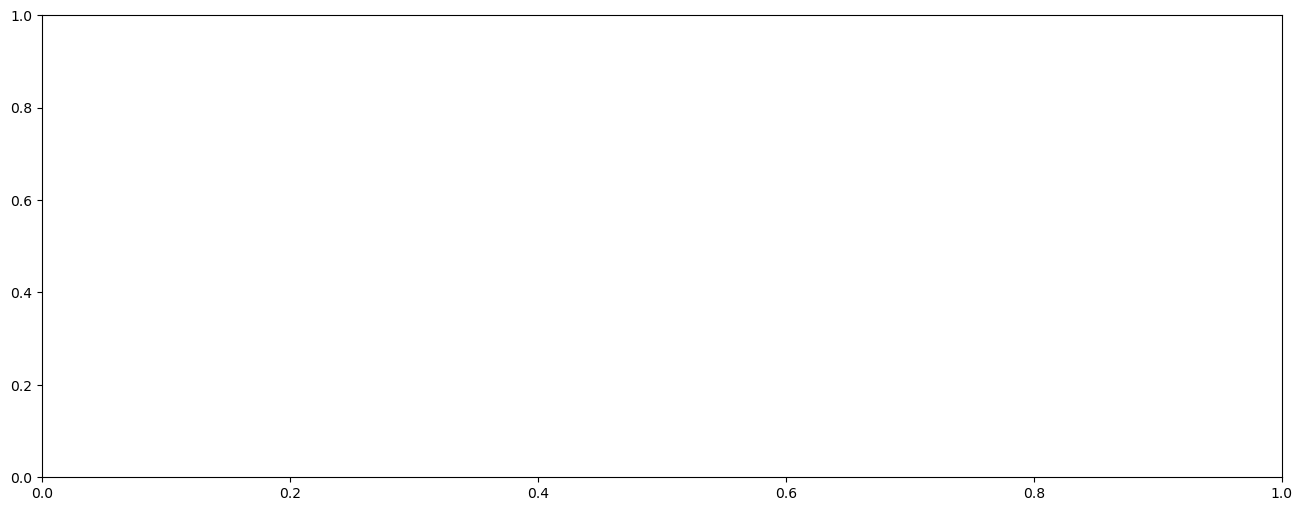

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(len(precision))
width = 0.2

# Plot bars
ax.bar(x - 1.5 * width, accuracy_per_digit.values(), width, label='Accuracy')
ax.bar(x - 0.5 * width, precision, width, label='Precision')
ax.bar(x + 0.5 * width, recall, width, label='Recall')
ax.bar(x + 1.5 * width, f1_score, width, label='F1 Score')

# Label and title
ax.set_xticks(x, fontsize=19)
ax.set_xticklabels(range(10),fontsize=14)
ax.set_xlabel('Digits',fontsize=19)
ax.set_title('Metrics per Digit', fontsize=19)
ax.legend(fontsize=16)

plt.savefig("generated_pdf_plots/lnn_analysis_4/metrics_per_digit_combined.pdf")
plt.show()

In [ ]:
def deviation_loss(y_true, y_pred):
    return np.sum((y_true - y_pred)**2, axis=1)

# Calculate the loss based on deviation
deviation_losses = deviation_loss(y_train_ohe, raw_outputs)

# Average loss per digit based on deviation
avg_deviation_loss_per_digit = {}
for digit in range(10):
    avg_deviation_loss_per_digit[digit] = np.mean(deviation_losses[train_y == digit])

# Plotting the average deviation loss per digit
plt.figure(figsize=(10, 6))
plt.bar(avg_deviation_loss_per_digit.keys(), avg_deviation_loss_per_digit.values())
plt.xlabel('Digits')
plt.ylabel('Average Deviation Loss')
plt.title('Average Deviation Loss per Digit')
plt.savefig("generated_pdf_plots/lnn_analysis_4/avg_deviation_loss.pdf")
plt.show()




In [ ]:
dev = (y_train_ohe - raw_outputs)**2
plt.bar(range(10),np.average(dev, axis=0))
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score per digit
precision, recall, f1_score, _ = precision_recall_fscore_support(train_y, predicted_labels, labels=range(10), zero_division=0)

# Plotting Precision, Recall, and F1-score per digit
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(precision))
width = 0.2

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_xticks(x)
ax.set_xticklabels(range(10))
ax.set_xlabel('Digits')
ax.set_title('Precision, Recall, and F1 Score per Digit', fontsize=19)
ax.legend(fontsize=16) 
plt.savefig("generated_pdf_plots/lnn_analysis_4/precision_recall_f1.pdf")
 # Increased font size for the legend

plt.show()

# Create a distribution of raw output scores to gauge the model's confidence
plt.figure(figsize=(10, 6))
plt.hist(raw_outputs.flatten(), bins=30, alpha=0.7)
plt.xlabel('Raw Output Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Raw Output Scores')

plt.show()

In [ ]:
from scipy.stats import pearsonr

# Initialize a matrix to store the correlation coefficients for each pixel-output neuron pair
num_pixels = x_train.shape[1]
num_output_neurons = raw_outputs.shape[1]
correlation_matrix = np.zeros((num_pixels, num_output_neurons))

# Calculate the correlation for each pair
for pixel_idx in range(num_pixels):
    for neuron_idx in range(num_output_neurons):
        correlation_matrix[pixel_idx, neuron_idx], _ = pearsonr(x_train[:, pixel_idx], raw_outputs[:, neuron_idx])

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True)
plt.xlabel('Output Neurons')
plt.ylabel('Pixel Index')
plt.title('Pixel-Output Neuron Correlation')
plt.show()

In [ ]:
# Plot 28x28 images showing the correlation of each pixel with each output neuron (digit)
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
reshaped_correlation_matrix = correlation_matrix.reshape(28, 28, num_output_neurons)
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.imshow(reshaped_correlation_matrix[:, :, i], cmap='coolwarm')
    ax.set_title(f"Digit {i}",fontsize=18)
    ax.axis('off')

plt.suptitle('Pixel-Output Neuron Correlation for Each Digit')
plt.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=0.1, h_pad=0.1)  # Adjust the layout to make images closer
plt.savefig("generated_pdf_plots/lnn_analysis_4/pixel_output_correlation.pdf")
plt.show()


In [ ]:
output_neuron_variability = np.var(raw_outputs, axis=0)

# Plotting the variance for each output neuron (digit)
plt.figure(figsize=(10, 6))
plt.bar(range(10), output_neuron_variability)
plt.xlabel('Output Neurons (Digits)')
plt.ylabel('Variance')
plt.title('Output Neuron Variability')
plt.show()

In [ ]:
with open('adj_mat.pkl', 'wb') as f:
            pickle.dump(net.adj_matrix.toarray(), f)

In [ ]:
print(net.adj_matrix.shape)

In [ ]:


# Initialize a 784x10 array to store the influences
influence_maps = np.zeros((784, 10))

# Loop through each input neuron (pixel)
for i in range(784):
    # Create an input array where only the i-th pixel is 'lit up'
    single_pixel_input = np.zeros((1, 784))
    single_pixel_input[0, i] = 1.0
    
    # Use your network's predict function to get the output
    _, output = net.predict(single_pixel_input, steps=6)
    
    # Record how much each output neuron is influenced by the i-th input neuron (pixel)
    influence_maps[i, :] = output

# Reshape the influence_maps into 10 separate 28x28 images
influence_images = [influence_maps[:, i].reshape(28, 28) for i in range(10)]

# Visualization
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(influence_images[i], cmap='viridis')
    ax.set_title(f'Output Neuron {i}')
    ax.axis('off')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score


# Initialize some arrays to store the metrics
stepwise_accuracies = []
stepwise_losses = []


# Loop through varying inference steps
for steps in range(2, 16):
    # Get predictions and raw outputs from your model
    y_pred, y_pred_raw = net.predict(x_train, steps=steps, activation_function='leaky_relu')

    # Calculate accuracy
    acc = accuracy_score(train_y, np.argmax(y_pred, axis=1))
    stepwise_accuracies.append(acc)

    # Calculate loss
    loss = log_loss(y_train_ohe, y_pred_raw)
    stepwise_losses.append(loss)
    
    print(f"Steps: {steps}, Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# Plotting the accuracies and losses
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(range(2, 16), stepwise_accuracies)
plt.title('Accuracy vs Steps' ,fontsize=19)
plt.xlabel('Steps',fontsize=19)
plt.ylabel('Accuracy',fontsize=19)

plt.subplot(1, 2, 2)
plt.plot(range(2, 16), stepwise_losses)
plt.title('Loss vs Steps',fontsize=19)
plt.xlabel('Steps',fontsize=19)
plt.ylabel('Loss',fontsize=19)

plt.tight_layout()
plt.show()


In [ ]:
steps_range = list(range(2, 16))

plt.figure()

plt.subplot(1, 2, 1)
plt.bar(steps_range, stepwise_accuracies, color='g')
plt.title('Accuracy vs Steps',fontsize=19)
plt.xlabel('Steps',fontsize=19)
plt.ylabel('Accuracy',fontsize=19)

plt.subplot(1, 2, 2)
plt.bar(steps_range, stepwise_losses, color='g')
plt.title('Loss vs Steps',fontsize=19)
plt.xlabel('Steps',fontsize=19)
plt.ylabel('Loss',fontsize=19 )

plt.tight_layout()
plt.savefig("generated_pdf_plots/lnn_analysis_4/accuracy_loss_vs_steps.pdf")
plt.show()


In [32]:
avg_accuracy_per_digit_lnn = {}
for digit in range(10):
    avg_accuracy_per_digit_lnn[digit] = []

In [33]:
for i in range(1,6):
    
    f = open('lnn_run'+str(i)+'_data/networks_lnn.pkl', 'rb') 
    networks = pickle.load(f)
    print("networks loaded")
    if isinstance(networks[0], tuple):
        n = []
        for i in networks:
            n.append(i[1])
        networks = n
    networks = evaluate_performance(networks, x_train[:1000], y_train_ohe[:1000])
    net = networks[0][1]
    predicted_ohe, raw_outputs = net.predict(x_train)
    predicted_labels = np.argmax(predicted_ohe, axis=1)

    accuracy_per_digit = {}
    for digit in range(10):
        correct_preds = np.sum((train_y == digit) & (predicted_labels == digit))
        total_preds = np.sum(train_y == digit)
        accuracy_per_digit[digit] = correct_preds / total_preds if total_preds > 0 else 0
        avg_accuracy_per_digit_lnn[digit].append(accuracy_per_digit[digit])
    print(accuracy_per_digit)

networks loaded
evaluating performances|||||||||||||||||||||||||||||| done! {0: 0.8951544825257471, 1: 0.9173835657075052, 2: 0.797079556898288, 3: 0.7357690425705431, 4: 0.8064019171516604, 5: 0.6679579413392362, 6: 0.850794187225414, 7: 0.8159616919393455, 8: 0.681763801059648, 9: 0.740796772566818}
networks loaded
evaluating performances|||||||||||||||||||||||||||||| done! {0: 0.0, 1: 0.9316226638979531, 2: 0.0, 3: 0.00016310552927744252, 4: 0.8825744608010955, 5: 0.8120273012359344, 6: 0.0003379520108144643, 7: 0.8422984836392657, 8: 0.8297726884293283, 9: 0.8078668683812406}
networks loaded
evaluating performances|||||||||||||||||||||||||||||| done! {0: 0.9395576565929428, 1: 0.9504598042123998, 2: 0.8487747566297416, 3: 0.0, 4: 0.0, 5: 0.7802988378527946, 6: 0.0, 7: 0.0, 8: 0.7827721756964622, 9: 0.9038493864515045}
networks loaded
evaluating performances|||||||||||||||||||||||||||||| done! {0: 0.9184534864089144, 1: 0.960990803915752, 2: 0.8309835515273581, 3: 0.7820910128853368

0 : [0.8951544825257471, 0.0, 0.9395576565929428, 0.9184534864089144, 0.924869154144859]
1 : [0.9173835657075052, 0.9316226638979531, 0.9504598042123998, 0.960990803915752, 0.9525363393651736]
2 : [0.797079556898288, 0.0, 0.8487747566297416, 0.8309835515273581, 0.7992614971466935]
3 : [0.7357690425705431, 0.00016310552927744252, 0.0, 0.7820910128853368, 0.7980753547545262]
4 : [0.8064019171516604, 0.8825744608010955, 0.0, 0.8931872646353989, 0.8248887367339952]
5 : [0.6679579413392362, 0.8120273012359344, 0.7802988378527946, 0.6841911086515403, 0.0]
6 : [0.850794187225414, 0.0003379520108144643, 0.0, 0.0, 0.0]
7 : [0.8159616919393455, 0.8422984836392657, 0.0, 0.851875498802873, 0.8166001596169193]
8 : [0.681763801059648, 0.8297726884293283, 0.7827721756964622, 0.3866005810972483, 0.7441462997778158]
9 : [0.740796772566818, 0.8078668683812406, 0.9038493864515045, 0.0, 0.7298705664817616]


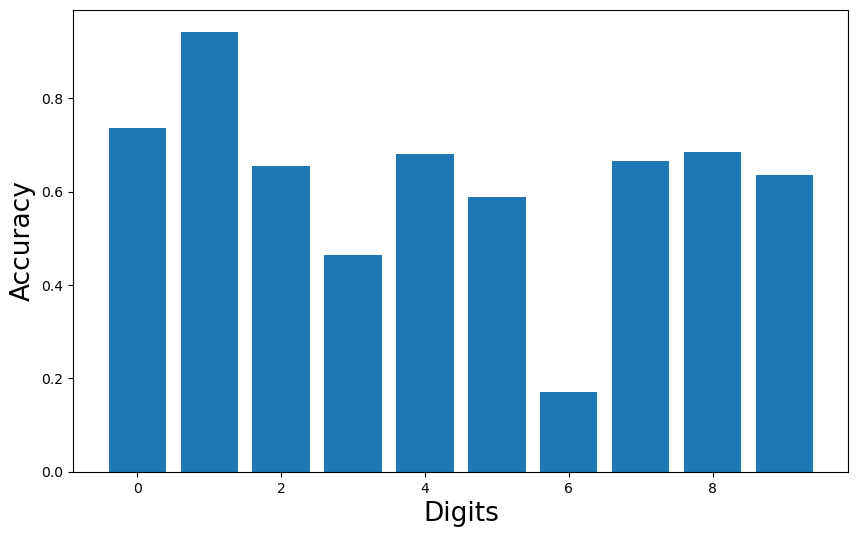

In [34]:
for digit in range(10):
    print(digit,":",avg_accuracy_per_digit_lnn[digit])
    avg_d = np.average(avg_accuracy_per_digit_lnn[digit])
    avg_accuracy_per_digit_lnn[digit] = avg_d
    
plt.figure(figsize=(10, 6))
plt.bar(avg_accuracy_per_digit_lnn.keys(), avg_accuracy_per_digit_lnn.values())
plt.xlabel('Digits',fontsize=19)
plt.ylabel('Accuracy',fontsize=19)
#plt.savefig("generated_pdf_plots/lnn_analysis_4/accuracy_per_digit.pdf")
plt.show()

In [37]:
accuracy_per_digit_nlnn = {}
lnn = False
f = open('nlnn_run3_data/networks.pkl', 'rb') 
networks = pickle.load(f)
print("networks loaded")
if isinstance(networks[0], tuple):
    n = []
    for i in networks:
        n.append(i[1])
    networks = n
networks = evaluate_performance(networks, x_train[:1000], y_train_ohe[:1000])
net = networks[0][1]
predicted_ohe, raw_outputs = net.predict(x_train,6)
predicted_labels = np.argmax(predicted_ohe, axis=1)
for digit in range(10):
        correct_preds = np.sum((train_y == digit) & (predicted_labels == digit))
        total_preds = np.sum(train_y == digit)
        accuracy_per_digit_nlnn[digit] = correct_preds / total_preds if total_preds > 0 else 0

networks loaded
evaluating performances|||||||||||||||||||||||||||||| done! 

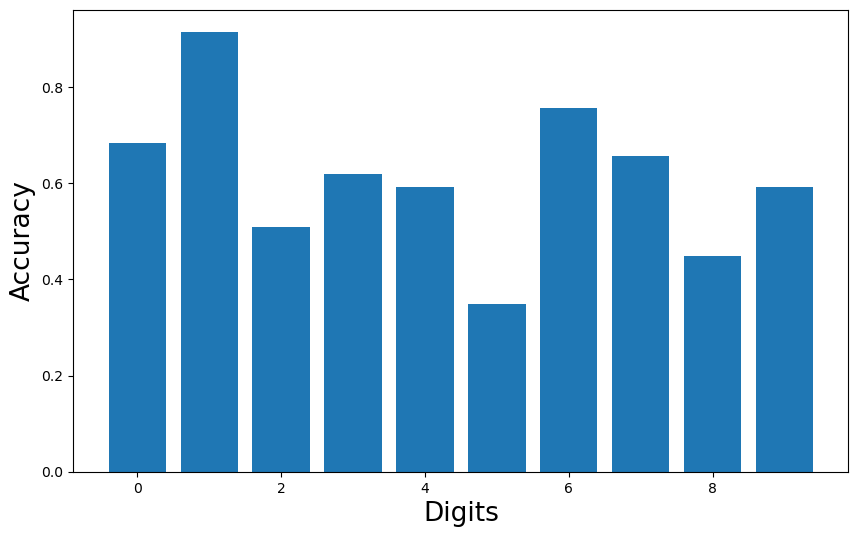

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(accuracy_per_digit_nlnn.keys(), accuracy_per_digit_nlnn.values())
plt.xlabel('Digits',fontsize=19)
plt.ylabel('Accuracy',fontsize=19)
#plt.savefig("generated_pdf_plots/lnn_analysis_4/accuracy_per_digit.pdf")
plt.show()

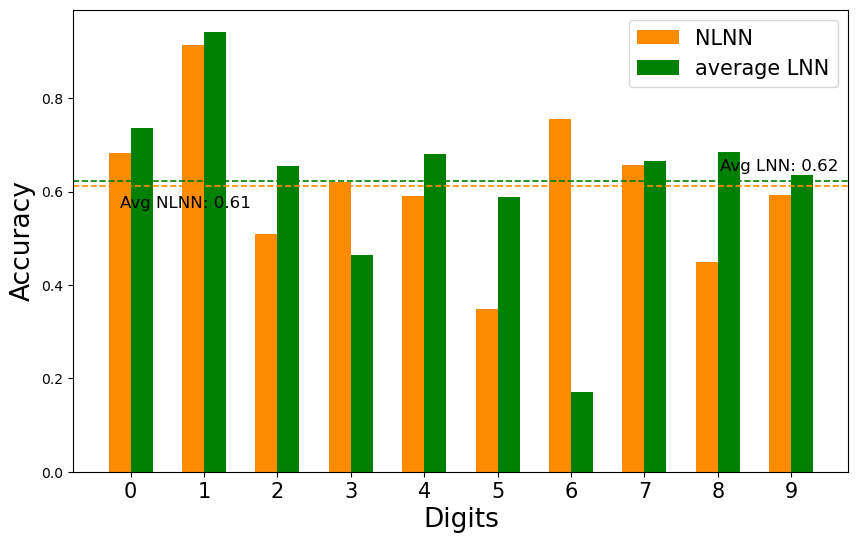

In [69]:
plt.figure(figsize=(10, 6))

# Calculate averages
avg_nlnn = np.mean(values_nlnn)
avg_lnn = np.mean(values_lnn)

# Create the bar plot
plt.bar(r1, values_nlnn, color='darkorange', width=barWidth, label='NLNN')
plt.bar(r2, values_lnn, color='green', width=barWidth, label='average LNN')

# Add horizontal lines for the averages
plt.axhline(avg_nlnn, color='darkorange', linestyle='--', linewidth=1.2)
plt.axhline(avg_lnn, color='green', linestyle='--', linewidth=1.2)

# Add text labels for averages
plt.text(0, avg_nlnn-0.02, f'Avg NLNN: {avg_nlnn:.2f}', color='black', verticalalignment='top', horizontalalignment='left', fontsize=12)
plt.text(len(keys)-0.2, avg_lnn+0.015, f'Avg LNN: {avg_lnn:.2f}', color='black', verticalalignment='bottom', horizontalalignment='right', fontsize=12)

# Labels and other stuff
plt.xlabel('Digits', fontsize=19)
plt.ylabel('Accuracy', fontsize=19)
plt.xticks([r + barWidth / 2 for r in range(len(keys))], keys, fontsize=15)
plt.legend(fontsize=15)

# Save plot
plt.savefig("generated_pdf_plots/lnn_analysis/accuracy_comparison.pdf")
plt.show()
